In [1]:
#import things
# import Libraries
# Built-in Python libraries
import os # functions for interacting w operating system

# 3rd-party libraries
import numpy as np # module for low-level scientific computing
import pymc3 as pm
import theano.tensor as tt
import pickle
import pylab as plt



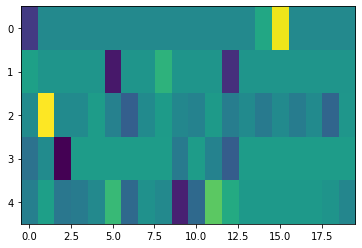

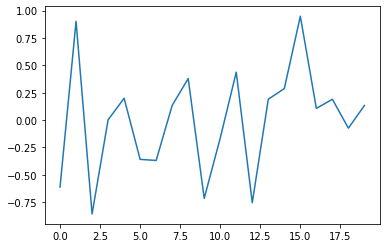

In [3]:
#Get name of directory where the data files and pickle file sits, and change to that directory for processing
dir_name = '/media/fastdata/brad_changepoint'
os.chdir(dir_name)

#open file
#open dump file
with open('znormdiff_array', 'rb') as f:
    znormdiff_matrix = pickle.load(f)

#diff vector
zdiff_mean = np.nanmean(znormdiff_matrix,axis=0)

#count_data
count_data = np.sum(znormdiff_matrix,axis=0)
count_data = zdiff_mean
n_count_data = len(count_data)

plt.imshow(znormdiff_matrix,aspect='auto')
plt.figure()
plt.plot(count_data)



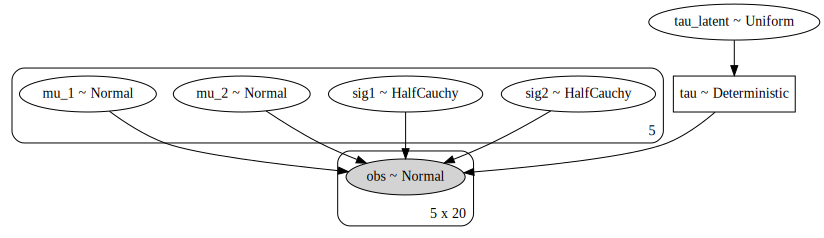

In [55]:
with pm.Model() as model:
    # Defining variables with priors
    alpha = count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
    sigma1 = pm.HalfCauchy('sig1', 1, shape = znormdiff_matrix.shape[0])
    sigma2 = pm.HalfCauchy('sig2', 1, shape = znormdiff_matrix.shape[0])

with model:
    idx = np.arange(n_count_data) # Index
    
    # Scaled beta mixture "somewhere in the middle" prior
    #a = 3
    #b = 3
    #tau_latent = pm.Beta('tau_latent', a, b)
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))[np.newaxis,:]
    mu_ = (1 - weight) * mu_1[:,np.newaxis] + weight * mu_2[:,np.newaxis]
    sigma_ = (1 - weight) * sigma1[:,np.newaxis] + weight * sigma2[:,np.newaxis]


with model:
    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=znormdiff_matrix)

pm.model_to_graphviz(model)

In [56]:
with model:
    #step = pm.Slice()
    step = pm.Metropolis()
    trace = pm.sample(5000, tune=1000, 
                    step = step,
                      chains = 4, cores = 4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:04<00:00, 4901.55draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [57]:
#pm.summary(trace).round(2)

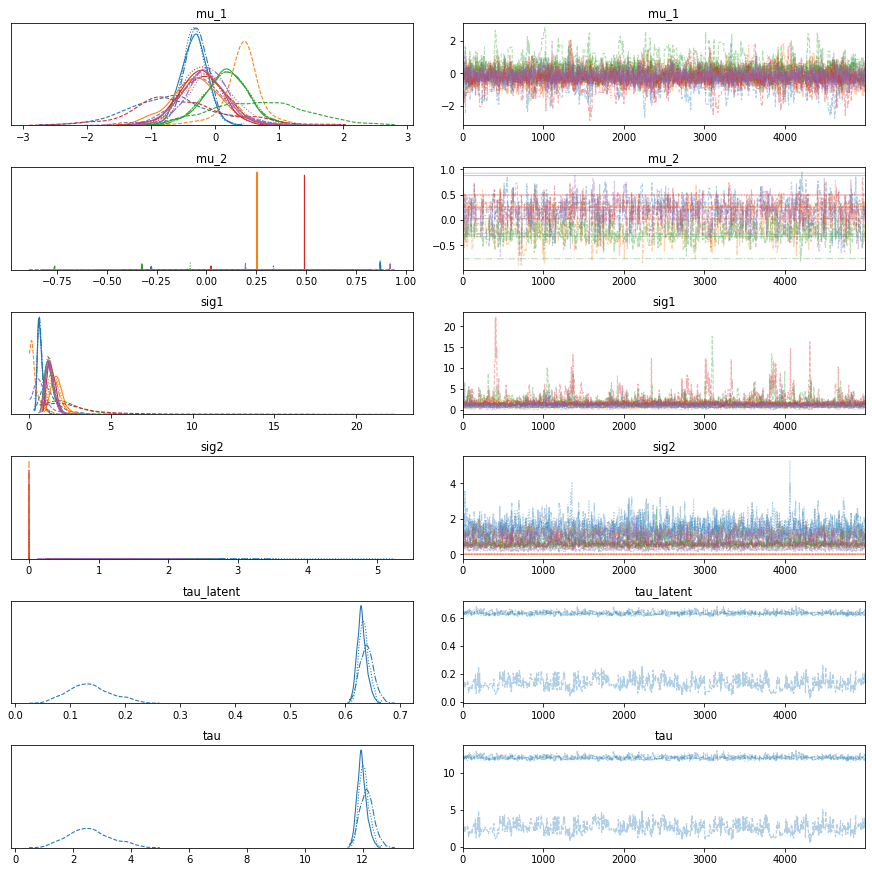

In [58]:
pm.traceplot(trace);

# Temporal Shuffled comparison

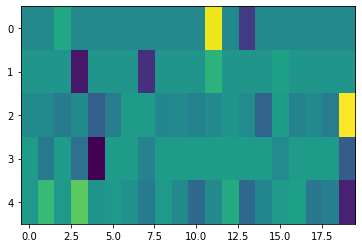

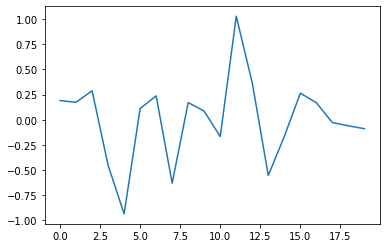

In [105]:
#Temporal shuffle
znormdiff_shuffle = np.array([np.random.permutation(x) for x in znormdiff_matrix]) 
zdiff_shuffle_mean = np.nanmean(znormdiff_shuffle,axis=0)

#count_data
count_data_shuffle = np.sum(znormdiff_shuffle,axis=0)
count_data_shuffle = zdiff_shuffle_mean
n_count_data = len(count_data_shuffle)

plt.imshow(znormdiff_shuffle,aspect='auto')
plt.figure()
plt.plot(count_data_shuffle)

INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.10-64/lock_dir/lock


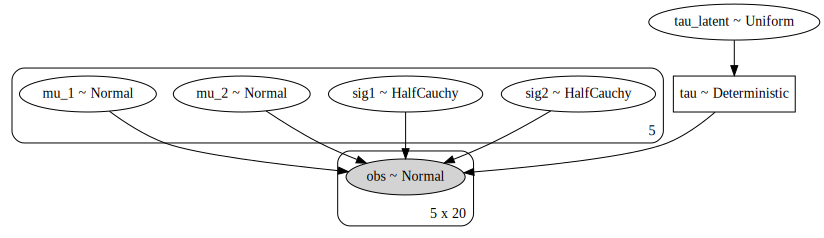

In [106]:
with pm.Model() as model:
    # Defining variables with priors
    alpha = count_data_shuffle.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
    sigma1 = pm.HalfCauchy('sig1', 1, shape = znormdiff_matrix.shape[0])
    sigma2 = pm.HalfCauchy('sig2', 1, shape = znormdiff_matrix.shape[0])

with model:
    idx = np.arange(n_count_data) # Index
    
    # Scaled beta mixture "somewhere in the middle" prior
    #a = 3
    #b = 3
    #tau_latent = pm.Beta('tau_latent', a, b)
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))[np.newaxis,:]
    mu_ = (1 - weight) * mu_1[:,np.newaxis] + weight * mu_2[:,np.newaxis]
    sigma_ = (1 - weight) * sigma1[:,np.newaxis] + weight * sigma2[:,np.newaxis]


with model:
    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=znormdiff_shuffle)

pm.model_to_graphviz(model)

In [107]:
with model:
    #step = pm.Slice()
    step = pm.Metropolis()
    trace = pm.sample(5000, tune=1000, 
                    step = step,
                      chains = 4, cores = 4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:05<00:00, 4148.93draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


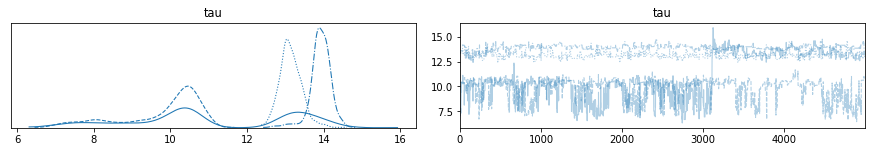

In [108]:
pm.traceplot(trace, varnames = ['tau']);

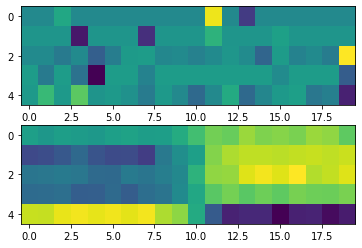

In [114]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
fig,ax=plt.subplots(2,1)
ax[0].imshow(znormdiff_shuffle,aspect='auto')
ax[1].imshow(np.mean(ppc['obs'],axis=0),aspect='auto')

# Random shuffle comparison

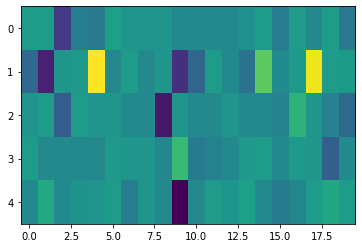

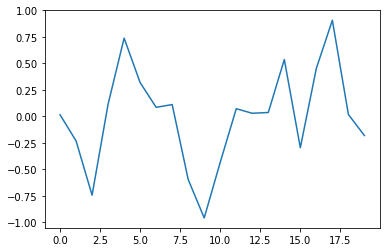

In [120]:
#Temporal shuffle
mat_shape = znormdiff_matrix.shape
znormdiff_shuffle =  np.reshape(np.random.permutation(znormdiff_matrix.flatten()), mat_shape)
zdiff_shuffle_mean = np.nanmean(znormdiff_shuffle,axis=0)

#count_data
count_data_shuffle = np.sum(znormdiff_shuffle,axis=0)
count_data_shuffle = zdiff_shuffle_mean
n_count_data = len(count_data_shuffle)

plt.imshow(znormdiff_shuffle,aspect='auto')
plt.figure()
plt.plot(count_data_shuffle)

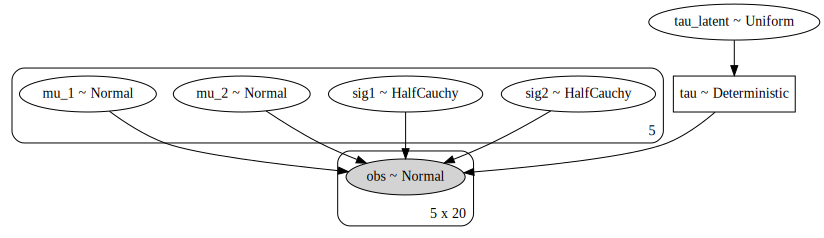

In [121]:
with pm.Model() as model:
    # Defining variables with priors
    alpha = count_data_shuffle.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
    sigma1 = pm.HalfCauchy('sig1', 1, shape = znormdiff_matrix.shape[0])
    sigma2 = pm.HalfCauchy('sig2', 1, shape = znormdiff_matrix.shape[0])

with model:
    idx = np.arange(n_count_data) # Index
    
    # Scaled beta mixture "somewhere in the middle" prior
    #a = 3
    #b = 3
    #tau_latent = pm.Beta('tau_latent', a, b)
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))[np.newaxis,:]
    mu_ = (1 - weight) * mu_1[:,np.newaxis] + weight * mu_2[:,np.newaxis]
    sigma_ = (1 - weight) * sigma1[:,np.newaxis] + weight * sigma2[:,np.newaxis]


with model:
    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=znormdiff_shuffle)

pm.model_to_graphviz(model)

In [123]:
with model:
    #step = pm.Slice()
    step = pm.Metropolis()
    trace = pm.sample(5000, tune=1000, 
                    step = step,
                      chains = 4, cores = 4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:05<00:00, 4783.16draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


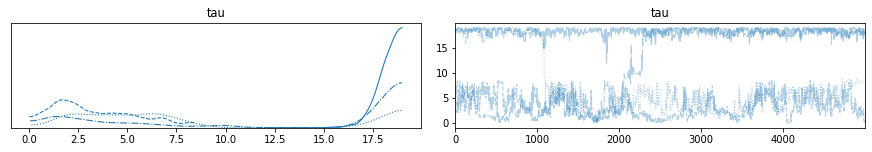

In [124]:
pm.traceplot(trace, varnames = ['tau']);

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 684.19it/s]


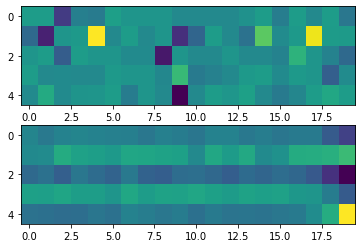

In [125]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
fig,ax=plt.subplots(2,1)
ax[0].imshow(znormdiff_shuffle,aspect='auto')
ax[1].imshow(np.mean(ppc['obs'],axis=0),aspect='auto')

## True random test

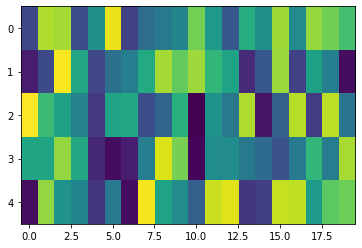

In [115]:
znormdiff_shuffle = np.random.random((5,len(idx)))
plt.imshow(znormdiff_shuffle,aspect='auto')

INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.10-64/lock_dir/lock


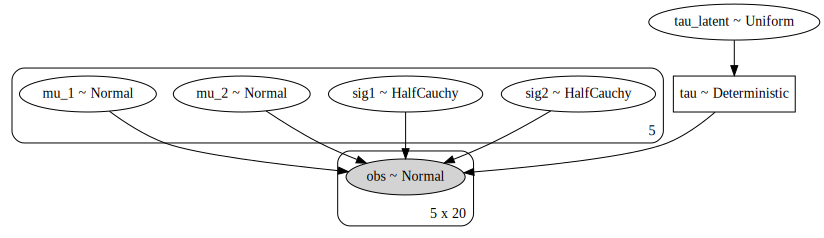

In [116]:
with pm.Model() as model:
    # Defining variables with priors
    alpha = count_data_shuffle.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
    sigma1 = pm.HalfCauchy('sig1', 1, shape = znormdiff_matrix.shape[0])
    sigma2 = pm.HalfCauchy('sig2', 1, shape = znormdiff_matrix.shape[0])

with model:
    idx = np.arange(n_count_data) # Index
    
    # Scaled beta mixture "somewhere in the middle" prior
    #a = 3
    #b = 3
    #tau_latent = pm.Beta('tau_latent', a, b)
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))[np.newaxis,:]
    mu_ = (1 - weight) * mu_1[:,np.newaxis] + weight * mu_2[:,np.newaxis]
    sigma_ = (1 - weight) * sigma1[:,np.newaxis] + weight * sigma2[:,np.newaxis]


with model:
    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=znormdiff_shuffle)

pm.model_to_graphviz(model)

In [117]:
with model:
    #step = pm.Slice()
    step = pm.Metropolis()
    trace = pm.sample(5000, tune=1000, 
                    step = step,
                      chains = 4, cores = 4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:05<00:00, 4517.86draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


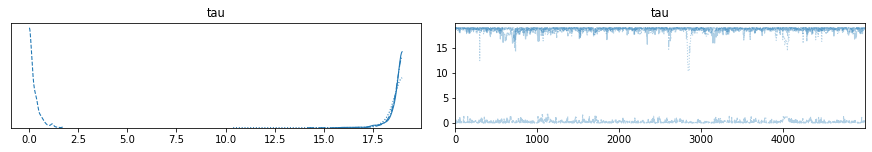

In [118]:
pm.traceplot(trace, varnames = ['tau']);

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 691.79it/s]


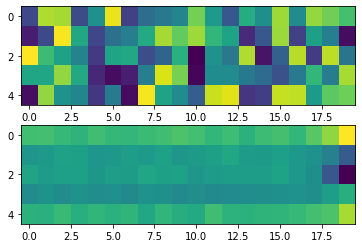

In [119]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
fig,ax=plt.subplots(2,1)
ax[0].imshow(znormdiff_shuffle,aspect='auto')
ax[1].imshow(np.mean(ppc['obs'],axis=0),aspect='auto')